In [1]:
import thd
from sklearn import cluster
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, ward, single, fcluster
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
from sklearn import preprocessing
import seaborn as sns
import datetime

In [35]:
# fetcher = thd.ThdData(aggregateType='OPC_Time_Average'
#                       ,interval='1min'
#                       ,file_name='tags'
#                       ,start_date='2020-02-16T00:00:00',
#                       end_date='2020-02-28T00:00:00')
# df = fetcher.download()
fetcher = thd.ThdData(aggregateType='OPC_Time_Average'
                      ,interval='1min'
                      ,file_name='tags'
                      ,number_of_days=80)
df = fetcher.download()

Root.GA3.177VI2041X.PV.Value yazıldı. (1/42)
18 s
Tahmini bitiş süre: 12 min

Root.GA3.177VI2040Y.PV.Value yazıldı. (2/42)
35 s

Root.GA3.177VI2038Z.PV.Value yazıldı. (3/42)
55 s

Root.GA3.177VI2039Z.PV.Value yazıldı. (4/42)
73 s

Root.GA3.177VI2035.PV.Value yazıldı. (5/42)
100 s

Root.GA3.177VI2036.PV.Value yazıldı. (6/42)
117 s

Root.GA3.177VI2034X.PV.Value yazıldı. (7/42)
2 min

Root.GA3.177VI2033Y.PV.Value yazıldı. (8/42)
2 min

Root.GA3.177TI2041A.PV.Value yazıldı. (9/42)
2 min

Root.GA3.177TI2041B.PV.Value yazıldı. (10/42)
2 min

Root.GA3.177TI2043A.PV.Value yazıldı. (11/42)
2 min

Root.GA3.177TI2043.PV.Value YAZILAMADI. (12/42)
2 min

Root.GA3.177TI2045A.PV.Value yazıldı. (13/42)
3 min

Root.GA3.177TI2045B.PV.Value yazıldı. (14/42)
3 min

Root.GA3.177TI2048A.PV.Value yazıldı. (15/42)
3 min

Root.GA3.177TI2048B.PV.Value yazıldı. (16/42)
3 min

Root.GA3.177TI2048C.PV.Value yazıldı. (17/42)
3 min

Root.GA3.177ZI2017A.PV.Value yazıldı. (18/42)
3 min

Root.GA3.177ZI2017B.PV.Value yaz

In [34]:
df.iloc[:,1:].head()

,177VI2040Y.PV,177VI2038Z.PV,177VI2039Z.PV,177VI2035.PV,177VI2036.PV,177VI2034X.PV,177VI2033Y.PV,177TI2041A.PV,177TI2041B.PV,177TI2043A.PV,...,177TI2055A.PV,177VI2005X.PV,177VI2005Y.PV,177VI2011Y.PV,177VI2011X.PV,177KI2025.PV,177TI2040B.PV,177TI2040A.PV,177TI2039A.PV,177TI2039B.PV
Zaman,,,,,,,,,,,,,,,,,,,,,
2019-09-29 18:41:57,11.825846,0.019465,0.005555,0.494408,0.400452,14.628851,14.054831,85.0,86.0,84.0,...,58.0,18.463725,20.942094,27.151255,14.224454,1484.596975,60.0,73.0,61.0,73.0
2019-09-29 18:42:57,12.249495,0.022539,0.006665,0.496011,0.396701,14.689203,14.187796,85.0,86.0,84.0,...,58.0,18.563293,21.332951,27.204017,14.176842,1484.520833,60.0,73.0,61.0,73.0
2019-09-29 18:43:57,12.394796,0.023307,0.010004,0.451943,0.401947,14.779740,14.113403,85.0,86.0,84.0,...,58.0,18.670575,21.322117,27.398620,14.283672,1485.329022,60.0,73.0,61.0,73.0
2019-09-29 18:44:57,11.451617,0.026808,0.013816,0.431234,0.392785,14.882923,14.171429,85.0,86.0,84.0,...,58.0,18.497452,21.128022,27.353783,14.299356,1486.038692,60.0,73.0,61.0,73.0
2019-09-29 18:45:57,12.125978,0.030919,0.021106,0.421610,0.398109,14.710901,14.196577,85.0,86.0,84.0,...,58.0,18.562892,21.241780,27.406115,14.227423,1485.097278,60.0,73.0,61.0,73.0


In [5]:
def scalesData(df,is_normalize=False,is_standardize=False):
    
    """ 
    Sets Timestamp as Index,
    Normalize data,
    Returns scaled data.

    Parameters: 
    df (pandas dataframe): Input data
    is_normalize (boolean)
    is_standardize (boolean)
    
    Returns: 
    df_scaled (pandas dataframe): Normalized or standardized dataframe. 
    """
    
    #If there is a timestamp column make it index
    if ('Zaman' in df.columns):
        df_timestamp = df['Zaman']
        X = df[:,:]
        
        df.set_index('Zaman', inplace=True)
    
    #Normalize dataframe
    if is_normalize:
        # Get column names first
        names = df.columns
        #Get scaled array
        df_scaled = preprocessing.normalize(df)
        #Create dataframe
        df_scaled = pd.DataFrame(df_scaled, columns=names)
    else:    
    #Standardize dataframe
        # Get column names first
        names = df.columns
        # Create the Scaler object
        scaler = preprocessing.StandardScaler()
        # Fit your data on the scaler object
        df_scaled = scaler.fit_transform(df)
        #Create scaled dataframe
        df_scaled = pd.DataFrame(df_scaled, columns=names)
        
    return df_scaled

In [6]:
def splitsTransposeData(df, n):
    """ 
    Returns evenly splitted and transposed 'n' number of dataframes. 

    Parameters: 
    df (pandas dataframe): Input data Should be scaled
    n (integer): number of split
    
    Returns: 
    df_list_T (list of dataframes): List of transposed dataframes.
    """
    #Get number of rows in the df
    n_rows_df= df.shape[0]
    
    #Create empty list to store dataframes
    df_list_T = []
    
    for i in range(n):
        df_slice=df.loc[i*n_rows_df/n:(i+1)*n_rows_df/n] #Slice dataframe
        df_slice_T = np.transpose(df_slice)
        df_list_T.append(df_slice_T) #append this sliced dataframe
    
    return df_list_T

In [7]:
def returnSensorClusters(df,n_clusters, linkage):
    """ 
    Returns clusters labels for every sensor 

    Parameters: 
    df (DataFrame): Dataframes that contains sensor data
    n_cluster (integer): number of clusters
    linkage (str): type of linkage e.g. 'ward', 'average', 'complete', 'single'
    
    Returns: 
    finger_print (Series): Series that contains sensors names as index cluster as value
    """
    
    #instantiate
    clust = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    #get cluster labels
    labels = clust.fit_predict(df)
    #create new series with these labels
    finger_print = pd.Series(data=labels, index=df.index)
    
    return finger_print.sort_values()

In [21]:
def healthCheck(list_of_dfs, finger_print, n_clusters, linkage):
    """ 
    Compares every dataframe with finger print to detect sensor fault. 

    Parameters: 
    list_of_dfs (DataFrame): List of dataframes to compare with finger print. Must be normalized and transposed.
    finger_print (Series): Units finger print that represents every sensors cluster
    n_cluster (integer): number of clusters
    linkage (str): type of linkage e.g. 'ward', 'average', 'complete', 'single'
    """


    for df in list_of_dfs:
        #Get unit sensor 
        unit_state = returnSensorClusters(df, n_clusters, linkage)
        #Compare this unit state with finger_print
        if finger_print.equals(unit_state):
            pass
        else:
            #Print which sensor is faulty.
            print(finger_print[np.invert(finger_print.eq(unit_state))].index.values)
            plt.figure(figsize=(10,10))
            plt.plot(np.transpose(df))
    

In [25]:
df_scaled = scalesData(df,is_normalize=True)
list_df = splitsTransposeData(df_scaled,200)

In [28]:
df_scaled.head()

,177VI2041X.PV,177VI2040Y.PV,177VI2038Z.PV,177VI2039Z.PV,177VI2035.PV,177VI2036.PV,177VI2034X.PV,177VI2033Y.PV,177TI2041A.PV,177TI2041B.PV,...,177TI2055A.PV,177VI2005X.PV,177VI2005Y.PV,177VI2011Y.PV,177VI2011X.PV,177KI2025.PV,177TI2040B.PV,177TI2040A.PV,177TI2039A.PV,177TI2039B.PV
0,0.001687,0.001935,0.000003,9.091383e-07,0.000081,0.000066,0.002394,0.002300,0.013910,0.014074,...,0.009492,0.003022,0.003427,0.004443,0.002328,0.242953,0.009819,0.011946,0.009983,0.011946
1,0.001686,0.002005,0.000004,1.090665e-06,0.000081,0.000065,0.002404,0.002322,0.013910,0.014074,...,0.009492,0.003038,0.003491,0.004452,0.002320,0.242941,0.009819,0.011946,0.009983,0.011946
2,0.001686,0.002028,0.000004,1.637067e-06,0.000074,0.000066,0.002419,0.002310,0.013910,0.014073,...,0.009491,0.003055,0.003489,0.004484,0.002337,0.243066,0.009819,0.011946,0.009982,0.011946
3,0.001625,0.001874,0.000004,2.260771e-06,0.000071,0.000064,0.002435,0.002319,0.013909,0.014073,...,0.009491,0.003027,0.003457,0.004476,0.002340,0.243175,0.009818,0.011946,0.009982,0.011946
4,0.001645,0.001981,0.000005,3.447175e-06,0.000069,0.000065,0.002403,0.002319,0.013883,0.014046,...,0.009473,0.003032,0.003469,0.004476,0.002324,0.242558,0.009800,0.011923,0.009963,0.011923


In [26]:
finger_print = returnSensorClusters(list_df[0],4,'ward')

['177TI2039B.PV' '177TI2039A.PV' '177TI2040A.PV' '177VI2005X.PV'
 '177VI2005Y.PV' '177VI2011Y.PV' '177VI2011X.PV' '177VI2041X.PV'
 '177VI2009Y.PV' '177VI2009X.PV' '177VI2013X.PV' '177ZI2017C.PV'
 '177ZI2017B.PV' '177ZI2017A.PV' '177VI2033Y.PV' '177VI2034X.PV'
 '177VI2036.PV' '177VI2035.PV' '177VI2039Z.PV' '177VI2038Z.PV'
 '177VI2040Y.PV' '177VI2013Y.PV' '177KI2025.PV' '177KI2030.PV']
['177TI2039B.PV' '177TI2039A.PV' '177TI2040A.PV' '177VI2005X.PV'
 '177VI2005Y.PV' '177VI2011Y.PV' '177VI2011X.PV' '177VI2041X.PV'
 '177VI2009Y.PV' '177VI2009X.PV' '177VI2013X.PV' '177ZI2017C.PV'
 '177ZI2017B.PV' '177ZI2017A.PV' '177VI2033Y.PV' '177VI2034X.PV'
 '177VI2036.PV' '177VI2035.PV' '177VI2039Z.PV' '177VI2038Z.PV'
 '177VI2040Y.PV' '177VI2013Y.PV' '177KI2025.PV' '177KI2030.PV']
['177TI2039B.PV' '177TI2039A.PV' '177TI2040A.PV' '177VI2005X.PV'
 '177VI2005Y.PV' '177VI2011Y.PV' '177VI2011X.PV' '177VI2041X.PV'
 '177VI2009Y.PV' '177VI2009X.PV' '177VI2013X.PV' '177ZI2017C.PV'
 '177ZI2017B.PV' '177ZI2017A.PV

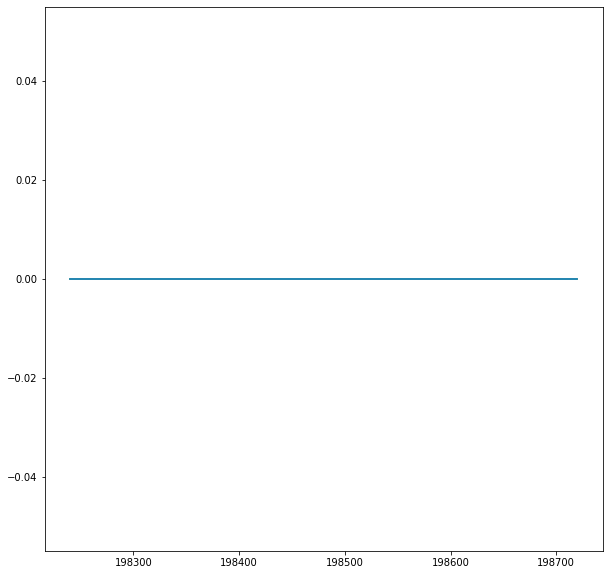

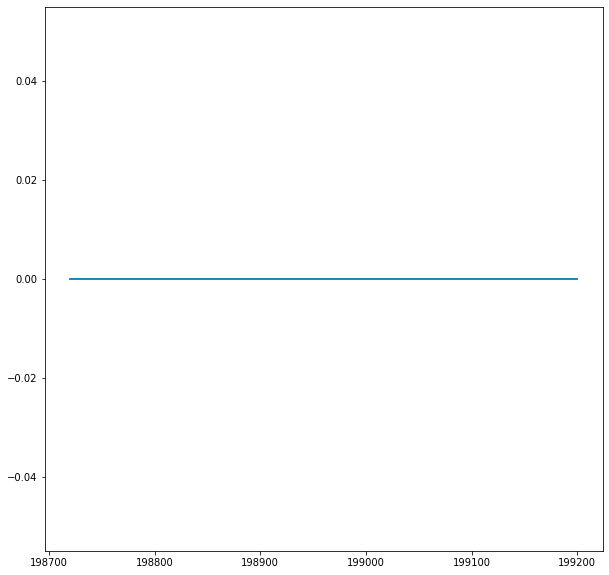

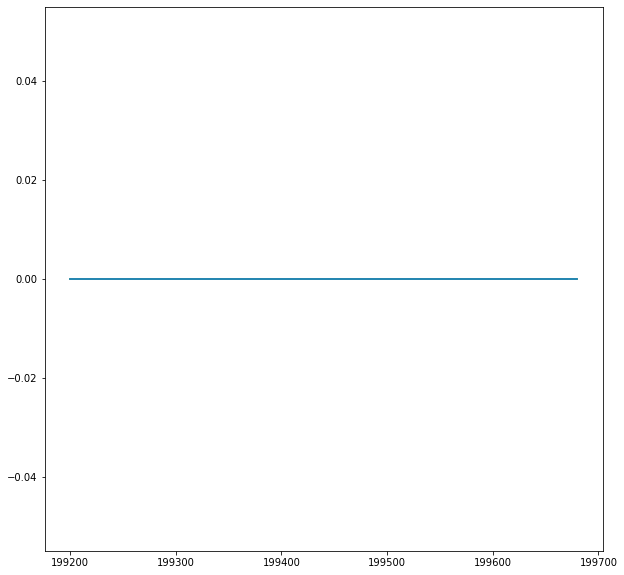

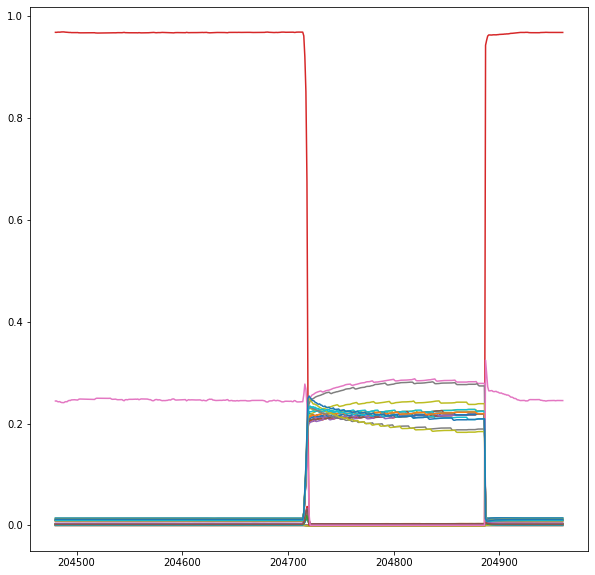

In [27]:
healthCheck(list_df, finger_print, 4, 'ward')

In [8]:
def plotDendogramsTranspose(df, n_plot, n_rows, n_cols, figsize, is_dropped=True):
    '''df: split etmek istediğin dataframe
       n_plot: kaç plota bölmek istediğimiz
    '''
    #Get number of rows in the df
    n_rows_df= df.shape[0]
    
    #Create empty list to store dataframes
    df_list = []
    
    #Create list for linkage_matrices
    linkages = []
    
    for i in range(n_plot):
        df_slice=df.loc[i*n_rows_df/n_plot:(i+1)*n_rows_df/n_plot] #Slice dataframe
        df_list.append(df_slice) #append this sliced dataframe
    
    #PLOTTING
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    
    for ax, df in zip(axes, df_list):
        #Transpose
        df_T=np.transpose(df)
        
        #Compute linkage matrix
        linkage_matrix = ward(df_T)
        
        #Append linkage matrix
        linkages.append(linkage_matrix)
        
        #Get dendrogram
        dendrogram(linkage_matrix,ax=ax[0], labels=df_T.index,orientation='left')

        ax[1].plot(df)
    
    return linkages, df_list

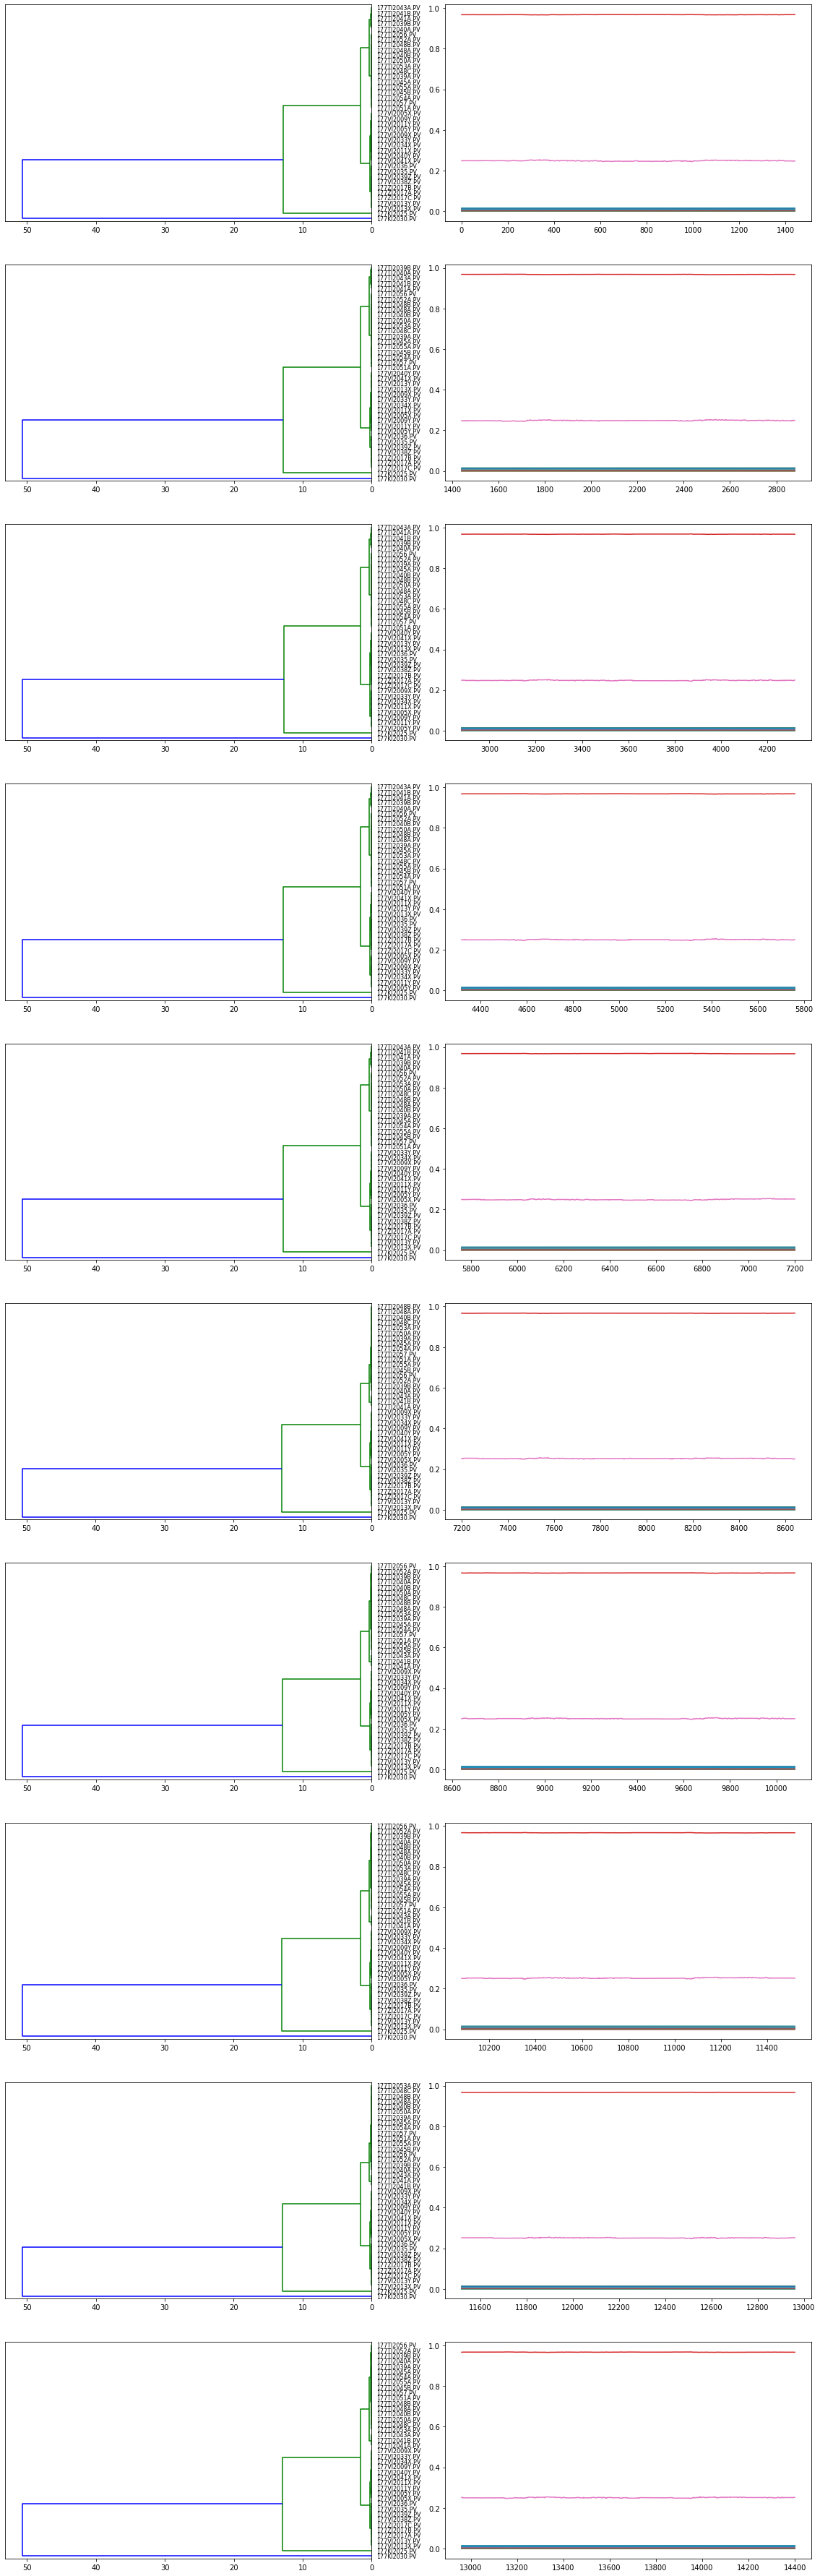

In [9]:
linkages, df_list=plotDendogramsTranspose(df_normalize,n_plot=20,n_rows=10,n_cols=2,figsize=(20,65))

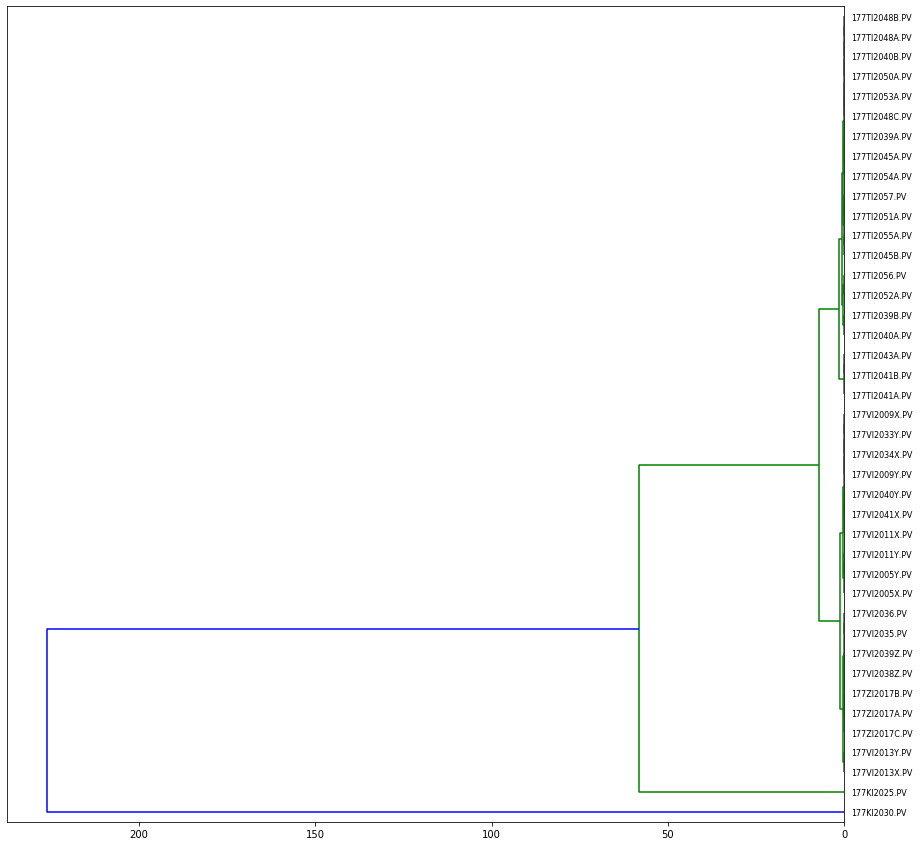

In [15]:
plt.figure(figsize=(15,15))
likage = ward(df_normalize_T)
dendrogram(likage,labels=df_normalize_T.index,orientation='left');

plt.show()

In [18]:
clust = cluster.AgglomerativeClustering(n_clusters=4,linkage='ward')
labels = clust.fit_predict(np.transpose(df_list[0]))
finger_print = pd.Series(data=labels, index=df_list[0].columns)
finger_print.sort_values()

177TI2039B.PV    0
177TI2052A.PV    0
177TI2039A.PV    0
177TI2056.PV     0
177TI2057.PV     0
177TI2053A.PV    0
177TI2054A.PV    0
177TI2048C.PV    0
177TI2048B.PV    0
177TI2048A.PV    0
177TI2045B.PV    0
177TI2045A.PV    0
177TI2043A.PV    0
177TI2041B.PV    0
177TI2041A.PV    0
177TI2055A.PV    0
177TI2040B.PV    0
177TI2040A.PV    0
177TI2051A.PV    0
177TI2050A.PV    0
177VI2005X.PV    1
177VI2005Y.PV    1
177VI2011Y.PV    1
177VI2011X.PV    1
177VI2041X.PV    1
177VI2009Y.PV    1
177VI2009X.PV    1
177VI2013X.PV    1
177ZI2017C.PV    1
177ZI2017B.PV    1
177ZI2017A.PV    1
177VI2033Y.PV    1
177VI2034X.PV    1
177VI2036.PV     1
177VI2035.PV     1
177VI2039Z.PV    1
177VI2038Z.PV    1
177VI2040Y.PV    1
177VI2013Y.PV    1
177KI2025.PV     2
177KI2030.PV     3
dtype: int64

In [ ]:
def healthcheck(finger_print,):

In [74]:
for df in df_list[1:]:
    labels = clust.fit_predict(np.transpose(df))
    unit_state = pd.Series(data=labels, index=df.columns)
    if (finger_print.equals(unit_state)):
        print('yey')
    else:
        print('NEY!!')
        print(finger_print[np.invert(seri1.finger_print(unit_state))].index.values)

yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey
yey


In [22]:
is_first_run = True
finger_print = pd.Series()
operation_stat = pd.Series()
clust = cluster.AgglomerativeClustering(n_clusters=4,linkage='single')
for df in df_list:
    if is_first_run:
        df_T = np.transpose(df)
        labels = clust.fit_predict(df_T)
        df_T['labels'] = labels
        finger_print = df_T['labels']
        is_first_run = False
        uniqueValues, occurCount = np.unique(labels, return_counts=True)
        print("Unique Values : " , uniqueValues)
        print("Occurrence Count : ", occurCount)
        
    else:
        df_T = np.transpose(df)
        labels = clust.fit_predict(df_T)
        df_T['labels'] = labels
        operation_stat = df_T['labels']
        uniqueValues, occurCount = np.unique(labels, return_counts=True)
        print("Unique Values : " , uniqueValues)
        print("Occurrence Count : ", occurCount)
        if finger_print.equals(operation_stat):
            print('same')
        else:
            print('not_same')

Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :  [0 1 2 3]
Occurrence Count :  [20 19  1  1]
same
Unique Values :